### Preamble

In [1]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt

from utils.plotting import *
from tqdm.notebook import tqdm
from typing import Tuple, NamedTuple
from gpflow.config import default_float
from gpflow_sampling.samplers import finite_fourier, decoupled

In [2]:
%matplotlib inline
set_default_rcParams(plt, fontsize=14, usetex=True)

In [3]:
SEED = 0
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Problem setup

In [4]:
class Flags(NamedTuple):
    """
    Settings for sample tests; default values are intentionally light-weight.
    """
    input_dim: Tuple[int] = [8] # dimensionality of input space X
    num_train: Tuple[int] = [4, 16, 64, 256, 1024]  # num. training points
    num_basis: Tuple[int] = [256, 1024, 4096]   # initial num. basis functions

    num_test: int = 1024  # num. test locations at which to sample
    num_batch: int = 100  # num. times to draw batches of samples
    batch_size: int = 100  # num. samples to draw per batch

flags = Flags()

### 2-Wasserstein distance between Gaussians

In [5]:
def matrix_sqrt(a: tf.Tensor) -> tf.Tensor:
    eigenvals, eigenvects = tf.linalg.eigh(a)
    return tf.matmul(eigenvects,
                     tf.sqrt(tf.maximum(eigenvals, 0.0)) * eigenvects,
                     transpose_b=True)


def gaussian_2wasserstein(ma: tf.Tensor,
                          Saa: tf.Tensor,
                          mb: tf.Tensor,
                          Sbb: tf.Tensor,
                          Laa: tf.Tensor = None) -> tf.Tensor:
    """
    Computes the 2-Wasserstein distance of $N(ma, Saa)$ from $N(mb, Sbb)$.
    """
    if Laa is None:
        Laa = matrix_sqrt(Saa)

    return tf.reduce_sum(tf.square(ma - mb)) \
           + tf.linalg.trace(Saa) \
           + tf.linalg.trace(Sbb) \
           - 2 * tf.linalg.trace(matrix_sqrt(Laa @ Sbb @ Laa))

### Estimate 2-Wasserstein distances

In [6]:
def estimate_moments(sampler, x, num_batch, batch_size):
    samples = []
    for i in range(num_batch):
        """
        [!] Passing reset_basis=False keeps the basis functions fixed,
        which is necessary since the resulting distribution would no
        longer be Gaussian (even thought its 1st and 2nd moments are
        actually better estimates to those of the true posterior).
        """
        sampler.reset_random_variables(reset_basis=False)
        samples.append(tf.squeeze(sampler(x), axis=-1))

    samples = tf.concat(samples, axis=0)
    m = tf.reduce_mean(samples, axis=0)
    S = samples - m[None]  # scratch variables
    S = tf.matmul(S, S, transpose_a=True)/(len(samples) - 1)
    return (m, S), samples

In [7]:
results = AttrDict()  # some minor book-keeping
def set_result(keys, obj, dest=results):
    for key in keys[:-1]:
        dest = dest.setdefault(key, {})
    dest[keys[-1]] = obj

In [8]:
gp = gpflow.models.GPR(data=(np.zeros([0, 1]), np.zeros([0, 1])),
                       kernel=gpflow.kernels.Matern52(),
                       mean_function=lambda X_data: 0.0,
                       noise_variance=1e-3)

fmt = '{l_bar}{bar}{n_fmt}/{total_fmt} [{elapsed}]{postfix}'  # omit ETA
for d in flags.input_dim:
    gp.kernel.lengthscales = 0.1 * np.sqrt(d)
    for n in tqdm(flags.num_train, bar_format=fmt):
        # Generate training and test sets
        X = tf.random.uniform(shape=[n, d], dtype=default_float())
        Knn = gp.kernel(X, full_cov=True)
        Snn = tf.linalg.set_diag(Knn, tf.linalg.diag_part(Knn) + gp.likelihood.variance)
        Lnn = tf.linalg.cholesky(Snn)
        y = tf.matmul(Lnn, tf.random.normal([n, 1], dtype=X.dtype))
        gp.data = (X, y)
        
        # Compute mean and covariance of exact posterior
        Xnew = tf.random.uniform(shape=[flags.num_test, d], dtype=default_float())
        m, S = map(tf.squeeze, gp.predict_f(Xnew, full_cov=True))
        L = matrix_sqrt(S)
        
        # Estimate 2-Wasserstein distances of approximate posteriors from ground truth
        for l in flags.num_basis:            
            # Generate draws using naive Fourier feature approximation
            sampler = finite_fourier(gp, gp.kernel, sample_shape=[flags.batch_size], num_basis=l + n)
            _m, _S = estimate_moments(sampler, Xnew, flags.num_batch, flags.batch_size)[0]
            wass = gaussian_2wasserstein(ma=m, Saa=S, Laa=L, mb=_m, Sbb=_S)
            set_result((d, 'rff', l, n), wass)

            # Generate draws using decoupled sampling
            sampler = decoupled(gp, gp.kernel, sample_shape=[flags.batch_size], num_basis=l)
            _m, _S = estimate_moments(sampler, Xnew, flags.num_batch, flags.batch_size)[0]    
            wass = gaussian_2wasserstein(ma=m, Saa=S, Laa=L, mb=_m, Sbb=_S)
            set_result((d, 'dec', l, n), wass)

### Visualize results

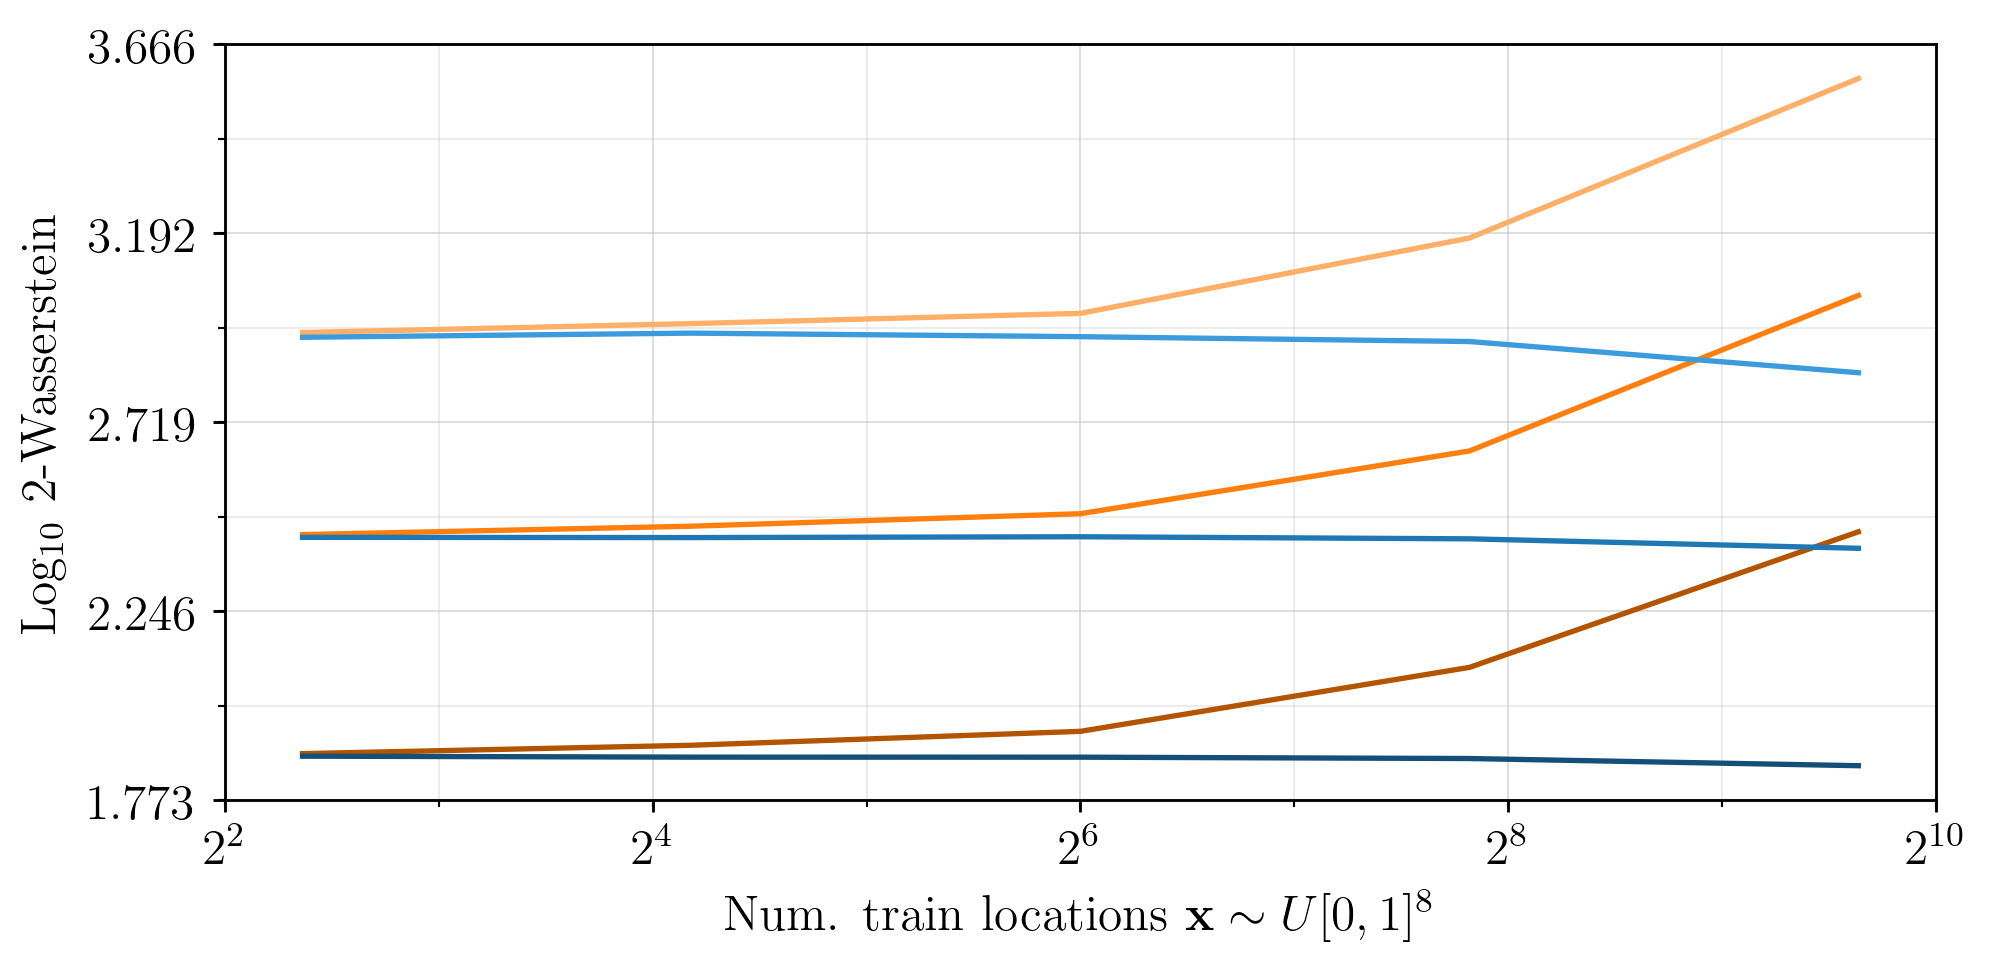

In [9]:
style = AttrDict()
style.rff = ObjectStyle(color='tab:orange')
style.dec = ObjectStyle(color='tab:blue')

ncols = len(flags.input_dim)
scale = 8/(2 * ncols)
fig, axes = plt.subplots(figsize=(2 * ncols * scale, scale), ncols=ncols)
axes = np.atleast_1d(axes)
axes[0].set_ylabel('Log$_{10}$ 2-Wasserstein')
for ax, (d, _results) in zip(axes, results.items()):
    ax.set_xlabel(f'Num. train locations $\mathbf{{x}} \sim U[0, 1]^{{{d}}}$')
    for name, _results in _results.items():
        for i, (l, _results) in enumerate(_results.items()):
            # Plot values in log-space
            counts, wass = zip(*_results.items())
            log2_n = np.log2(counts)
            log10_w = np.log10(wass)
            
            # Use darker colors to denote use of more basis functions
            delta = np.linspace(5/3, 1/3, len(flags.num_basis) + 2)[i + 1]
            color = adjust_lightness(style[name].color, delta)
            ax.plot(log2_n, log10_w, color=color, linewidth=1.5)

    ax.set_xticks(log2_n)
    ax.set_xticklabels((f'$2^{{{int(ln)}}}$' for ln in log2_n))
    format_axes(ax=ax, num_major=5, num_minor=9, grid='both')

plt.tight_layout()